** Figure 13 (a): Qualitative comparison of experimentally measured and simulated
vapor field with their iso-contours at different times.** 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import csv
import pandas as pd
from natsort import natsorted
import os
from scipy.interpolate import griddata
from matplotlib.ticker import ScalarFormatter

In [2]:
exp_concentration_matrix = np.load('../../data/experimental_concentration_data/concentration_matrix_0_11.npy')
#exp_concentration_matrix = np.flipud(exp_concentration_matrix)
nan_rows = np.isnan(exp_concentration_matrix).all(axis=1)
exp_concentration_matrix = exp_concentration_matrix[~nan_rows]
# Iterate over the rows and copy values from the row before NaN row
for i in range(1, exp_concentration_matrix.shape[0]):
    if np.isnan(exp_concentration_matrix[i]).any():
        exp_concentration_matrix[i] = exp_concentration_matrix[i-1]
print("exp_concentration_matrix: " + str(exp_concentration_matrix.shape))

# x1 = np.linspace(0.0, 0.011, 2000)
# y1 = np.linspace(0.0, 0.0105765, 1923) # cause 1923 pixels times 5.5E-06 m 
x1 = np.linspace(0.0105, 0.0215, 2000)
y1 = np.linspace(0.0, 0.0105765, 1923) # cause 1923 pixels times 5.5E-06 m 
#y1 = np.linspace(0.0, 0.002, 1923)
yf = np.flipud(y1)

# Create a grid of points
xi, yi = np.meshgrid(x1, y1)
xii, yf = np.meshgrid(x1, yf)

# Flatten the coordinates for interpolation
points = np.column_stack((xi.flatten(), yi.flatten()))


exp_concentration_matrix: (1923, 2000)


In [3]:
df = pd.read_csv('../contourPlots_comparison/fieldData/time_4000.csv')#, sep=',', engine='python')

sim_concentration = df['C'].values
x = df['coords_0'].values
y = df['coords_1'].values
#x = x-0.1015

interpolated_sim_conc = griddata((x, y), sim_concentration, (xi, yi), method='cubic')
# create a triangulation of the (coords_0, coords_1) points
# triang = mtri.Triangulation(x,y)
# interpolator = mtri.CubicTriInterpolator(triang, sim_concentration, kind='geom')
# interpolated_sim_conc = interpolator(xi,yi)
print("interpolated_sim_conc: " + str(interpolated_sim_conc.shape))

interpolated_sim_conc: (1923, 2000)


In [4]:
# Flatten the array for interpolation
values = exp_concentration_matrix.flatten()

# Interpolate the values onto the grid
interpolated_exp_conc = griddata(points, values, (xii, yf), method='cubic')

# Print the shape of interpolated values
print("interpolated_exp_conc: " + str(interpolated_exp_conc.shape))


interpolated_exp_conc: (1923, 2000)


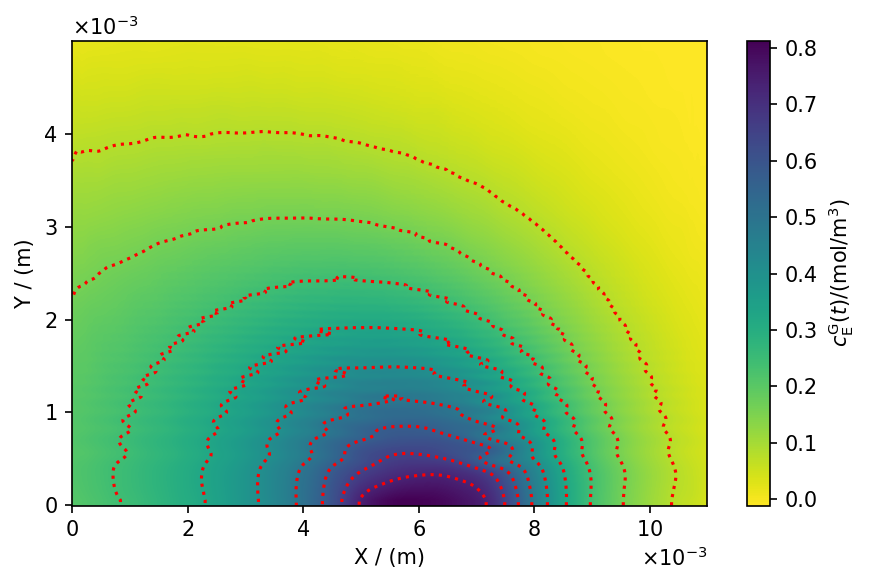

In [5]:
fig, ax = plt.subplots(1, 1, dpi=150)  # 1 row, 2 columns
axs = [ax]
# minus sign to shift axis on scale of 0-11mm
xi = xi - 0.0105

# Define the maximum y-axis value you want to plot up to
max_y_value_exp = 0.005  # Set the desired maximum y-axis value

# Find the index in your yi array that corresponds to the maximum y-value
#max_y_index = int(max_y_value / (yi[1] - yi[0]))
max_y_index_exp = np.searchsorted(yi[:, 0], max_y_value_exp)

pcm1 = axs[0].pcolormesh(xi[:max_y_index_exp, :],yi[:max_y_index_exp, :],interpolated_exp_conc[:max_y_index_exp, :],cmap='viridis_r',shading='auto')

max_exp_concentration = np.max(interpolated_exp_conc)

levelsExp = np.asarray([0.1, 0.2, 0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9])*max_exp_concentration #0.1, 0.2, 0.3,
axs[0].contour(xi[:max_y_index_exp, :],yi[:max_y_index_exp, :],interpolated_exp_conc[:max_y_index_exp, :], colors='red', linestyles='dotted', levels=levelsExp)

# Add colorbars with units
cbar1 = plt.colorbar(pcm1, ax=axs[0], label='$c_{\mathrm{E}}^{\mathrm{G}}(t) / \mathrm{(mol/m^3)}$')

# Use ScalarFormatter to format the x-axis ticks
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))  # Set the power limits to (-3, -3) to keep 10^-3 at the corner
axs[0].xaxis.set_major_formatter(formatter)
axs[0].yaxis.set_major_formatter(formatter)
# Add x and y labels
axs[0].set_xlabel('X / (m)')
axs[0].set_ylabel('Y / (m)')
#plt.savefig('../figures/contourExp_time4s.pdf', bbox_inches='tight')
plt.savefig('../figures/contourExp_time4s_re2.png', bbox_inches='tight')
# Adjust the layout to prevent subplot overlap
plt.tight_layout()
plt.show()


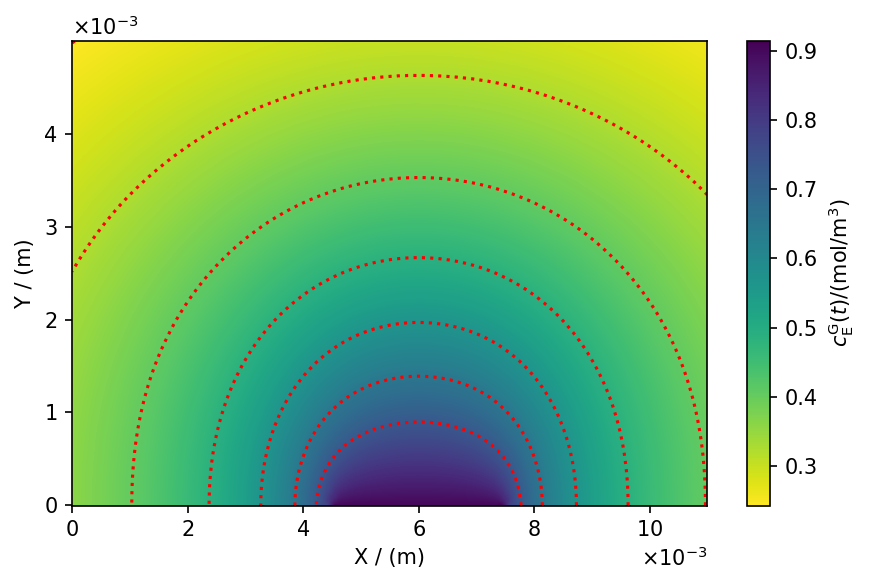

In [6]:
fig, ax = plt.subplots(1, 1, dpi=150) 
axs = [ax]

# Define the maximum y-axis value you want to plot up to
max_y_value = 0.005  # Set the desired maximum y-axis value

# Find the index in your yi array that corresponds to the maximum y-value
#max_y_index = int(max_y_value / (yi[1] - yi[0]))
max_y_index = np.searchsorted(yi[:, 0], max_y_value)

pcm2 = axs[0].pcolormesh(xi[:max_y_index, :],yi[:max_y_index, :],interpolated_sim_conc[:max_y_index, :],cmap='viridis_r',shading='auto')

max_sim_concentration = np.max(interpolated_sim_conc)

levelsSim = np.asarray([ 0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8, 0.9])*max_exp_concentration #0.1, 0.2, 0.3,
axs[0].contour(xi[:max_y_index, :],yi[:max_y_index, :],interpolated_sim_conc[:max_y_index, :], colors='red', linestyles='dotted', levels=levelsSim)

# Use ScalarFormatter to format the x-axis ticks
formatter = ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-3, -3))  # Set the power limits to (-3, -3) to keep 10^-3 at the corner
axs[0].xaxis.set_major_formatter(formatter)
axs[0].yaxis.set_major_formatter(formatter)

axs[0].set_xlabel('X / (m)')
axs[0].set_ylabel('Y / (m)')
cbar2 = plt.colorbar(pcm2, ax=axs[0], label='$c_{\mathrm{E}}^{\mathrm{G}}(t) / \mathrm{(mol/m^3)}$')
#plt.savefig('../figures/contourSim_time4s.pdf', bbox_inches='tight')
plt.savefig('../figures/contourSim_time4s_re2.png', bbox_inches='tight')
plt.tight_layout()
plt.show()